# Gradient Boosting Model inital attempt

In [42]:
%pip install xgboost

In [43]:
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, roc_curve

In [44]:
df= pd.read_parquet("final_data.parquet")
df

,constructorId,constructor_name,constructorStandingsId,raceId,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,FastLap_Rate,Points_Per_Entry,Years_Active,Champion,driverRef,code,driverStandingsId,points,position,driver_wins
0,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,0.064067,5.78273,19,True,alonso,ALO,68613,10.0,5,0
1,1,McLaren,26976.0,990.0,3.0,0.0,15655.0,10.0,2,3,...,0.064067,5.78273,19,True,alonso,ALO,68693,16.0,4,0
2,1,McLaren,26966.0,991.0,4.0,0.0,15664.0,6.0,3,17,...,0.064067,5.78273,19,True,alonso,ALO,68673,22.0,6,0
3,1,McLaren,26986.0,992.0,4.0,0.0,15675.0,8.0,4,73,...,0.064067,5.78273,19,True,alonso,ALO,68713,28.0,6,0
4,1,McLaren,26996.0,993.0,5.0,0.0,15685.0,4.0,5,4,...,0.064067,5.78273,19,True,alonso,ALO,68733,32.0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,214,Alpine F1 Team,28688.0,1118.0,6.0,0.0,16864.0,7.0,20,18,...,0.000000,3.25000,6,False,ocon,OCO,72447,46.0,12,0
1765,214,Alpine F1 Team,28698.0,1119.0,6.0,0.0,16872.0,12.0,21,80,...,0.000000,3.25000,6,False,ocon,OCO,72491,58.0,12,0
1766,214,Alpine F1 Team,28698.0,1119.0,6.0,0.0,16872.0,12.0,21,80,...,0.027523,3.06422,6,False,gasly,GAS,72482,62.0,11,0
1767,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,0.000000,3.25000,6,False,ocon,OCO,72513,58.0,12,0


In [45]:
#driver data in the wet
df['wet_race']= (df['Rainfall'].astype(float)> 0).astype(int)


wet_driver= df[df['wet_race']== 1].groupby('driverId').agg({
    'driver_wins': 'mean',
    'position': 'mean',
    'driverId': 'count'
}).rename(columns={'driver_wins': 'wet_win_rate', 'position': 'wet_avg_position', 'driverId': 'wet_races_count'})

df= df.merge(wet_driver, on='driverId', how='left')

In [46]:
#constructor data in the wet

wet_constructor= df[df['wet_race']== 1].groupby('constructorId').agg({
    'constructor_wins': 'mean',
    'constructor_pos': 'mean',
    'constructorId': 'count'
}).rename(columns={'constructor_wins': 'constructor_wet_win_rate', 'constructor_pos': 'constructor_wet_avg_position', 'constructorId': 'constructor_wet_races_count'})

df= df.merge(wet_constructor, on='constructorId', how='left')

In [47]:
#create binary variable for classifier
df['win']= (df['position']== 1).astype(int)

#features to keep for driver win predictions
features= [
    'grid', 'laps', 'results_points', 'fastestLapSpeed',  #race and performance info
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',  #weather/track conditions
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums', #rest is for driver performance
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active',
    'wet_race', 'wet_win_rate', 'wet_avg_position', 'wet_races_count',
    'constructor_wet_win_rate', 'constructor_wet_avg_position', 'constructor_wet_races_count'
]

#convert to numerical
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#only use rows will full data
df= df.dropna(subset=features+ ['win']+ ['race_name']+ ['constructor_name']+ ['constructorId'])

X= df[features]
y= df['win']

In [48]:
#Kfold cross validation
kf= StratifiedKFold(n_splits=5, shuffle=True)

#fold metrics
f_accuracy=[]
f_auc= []
f_precision= []
f_recall=[]
f_f1=[]

#lists for all kfold predictions and things
f_indicies=[]
f_predictions=[]
f_probs=[]

In [49]:
#Perform cross-validation
#followed a guide for this

win_ratio = y.mean() #win ratio for a better base_score for model

for fold, (train, test) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}/{kf.n_splits}")
    
    X_train_fold, X_test_fold= X.iloc[train], X.iloc[test]
    y_train_fold, y_test_fold= y.iloc[train], y.iloc[test]
    
    model= xgb.XGBClassifier(eval_metric='logloss', base_score=win_ratio,
                             learning_rate=0.5, n_estimators=100, max_depth=3,
                             subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1,
                             random_state=42)
    
    model.fit(X_train_fold, y_train_fold)
    
    #predict
    xgbYPred= model.predict(X_test_fold)
    #trying a threshold instead
    # threshold= 0.3
    xgbYPred_probability= model.predict_proba(X_test_fold)[:, 1]
    # xgbYPred= (xgbYPred_probability > threshold).astype(int)
    
    #save predictions (extend not append)
    f_indicies.extend(test)
    f_predictions.extend(xgbYPred)
    f_probs.extend(xgbYPred_probability)
    
    acc= accuracy_score(y_test_fold, xgbYPred)
    auc= roc_auc_score(y_test_fold, xgbYPred_probability)
    report= classification_report(y_test_fold, xgbYPred, output_dict=True)
    
    #store for the overall metric
    f_accuracy.append(acc)
    f_auc.append(auc)
    
    #store precision, recall, and f1 for race win (1)
    f_precision.append(report['1']['precision'])
    f_recall.append(report['1']['recall'])
    f_f1.append(report['1']['f1-score'])
    
    #fold metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_fold, xgbYPred))


Fold 1/5
Accuracy: 0.9572
AUC: 0.9678
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       304
           1       0.74      0.61      0.67        23

    accuracy                           0.96       327
   macro avg       0.85      0.80      0.82       327
weighted avg       0.95      0.96      0.96       327


Fold 2/5
Accuracy: 0.9509
AUC: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       304
           1       0.62      0.68      0.65        22

    accuracy                           0.95       326
   macro avg       0.80      0.83      0.81       326
weighted avg       0.95      0.95      0.95       326


Fold 3/5
Accuracy: 0.9540
AUC: 0.9481
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       304
           1       0.71      0.55      0.62        

In [50]:
#overall metrics
print("\n--- Overall Cross-Validation Results ---")
print(f"Mean Accuracy: {np.mean(f_accuracy):.4f}")
print(f"Mean AUC: {np.mean(f_auc):.4f}")
print(f"Mean Precision (wins): {np.mean(f_precision):.4f}")
print(f"Mean Recall (wins): {np.mean(f_recall):.4f}")
print(f"Mean F1 (wins): {np.mean(f_f1):.4f}")


--- Overall Cross-Validation Results ---
Mean Accuracy: 0.9528
Mean AUC: 0.9597
Mean Precision (wins): 0.6830
Mean Recall (wins): 0.5901
Mean F1 (wins): 0.6302


In [51]:
#followed a guide for this
def plot_kfold_visualization(X, y, kf, sample_size=None):
    if sample_size and sample_size < len(X):
        sample_idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]
        all_indices = np.arange(len(X_sample))
    else:
        X_sample = X
        y_sample = y
        all_indices = np.arange(len(X))
    
    fig, axes = plt.subplots(kf.n_splits, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('5-Fold Cross-Validation Visualization', fontsize=16)
    
    for i, (train_idx, test_idx) in enumerate(kf.split(X_sample, y_sample)):

        train_y = np.random.normal(i+0.25, 0.05, size=len(train_idx))
        test_y = np.random.normal(i+0.75, 0.05, size=len(test_idx))
        

        axes[i].scatter(all_indices[train_idx], train_y, 
                      c='blue', s=30, alpha=0.6, label='Training')
        axes[i].scatter(all_indices[test_idx], test_y, 
                      c='red', s=30, alpha=0.7, label='Testing')
        

        axes[i].set_ylabel(f'Fold {i+1}', fontsize=12)
        axes[i].set_ylim(i, i+1)
        

        train_wins = sum(y_sample.iloc[train_idx])
        test_wins = sum(y_sample.iloc[test_idx])
        axes[i].text(len(X_sample)*1.01, i+0.3, 
                    f"Train: {len(train_idx)} samples\n({train_wins} wins)",
                    va='center', fontsize=10)
        axes[i].text(len(X_sample)*1.01, i+0.7, 
                    f"Test: {len(test_idx)} samples\n({test_wins} wins)",
                    va='center', fontsize=10)
    

    plt.xlabel('Data points', fontsize=12)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, right=0.85)
    plt.show()

In [52]:
#also from online
def kfold_partition(X, y, kf, figsize=(12, 7), sample_rate=0.1):

    n_samples = len(X)
    if sample_rate < 1.0:
 
        sample_size = int(n_samples * sample_rate)
        sample_idx = np.random.choice(n_samples, sample_size, replace=False)
        sample_idx = sorted(sample_idx)  
    else:
        sample_idx = np.arange(n_samples)
    
   
    n_folds = kf.n_splits
    fold_matrix = np.zeros((n_folds, len(sample_idx)))
    
    
    all_splits = list(kf.split(X, y))
    
   
    for i, (train_idx, test_idx) in enumerate(all_splits):
    
        test_set = set(test_idx)
        for j, idx in enumerate(sample_idx):
            fold_matrix[i, j] = 1 if idx in test_set else 0 
    

    plt.figure(figsize=figsize)
    
  
    cmap = plt.cm.RdBu_r  
    
  
    plt.imshow(fold_matrix, cmap=cmap, interpolation='nearest',
              aspect='auto', alpha=1.0)
    
  
    for i in range(1, n_folds):
        plt.axhline(y=i-0.5, color='black', linestyle='-', alpha=0.3)
    

    plt.xlabel('Data points (sampled)', fontsize=12)
    plt.ylabel('Fold', fontsize=12)
    plt.title('K-Fold Cross-Validation Partition', fontsize=14)
    plt.yticks(range(n_folds), [f'Fold {i+1}' for i in range(n_folds)])
    
  
    test_pct = len(test_idx) / n_samples * 100
    plt.figtext(0.01, 0.01, f'Test set: {test_pct:.1f}% of data', 
                fontsize=10, ha='left')
    
  
    red_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7, label='Testing set')
    blue_patch = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.7, label='Training set')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right', 
               bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()

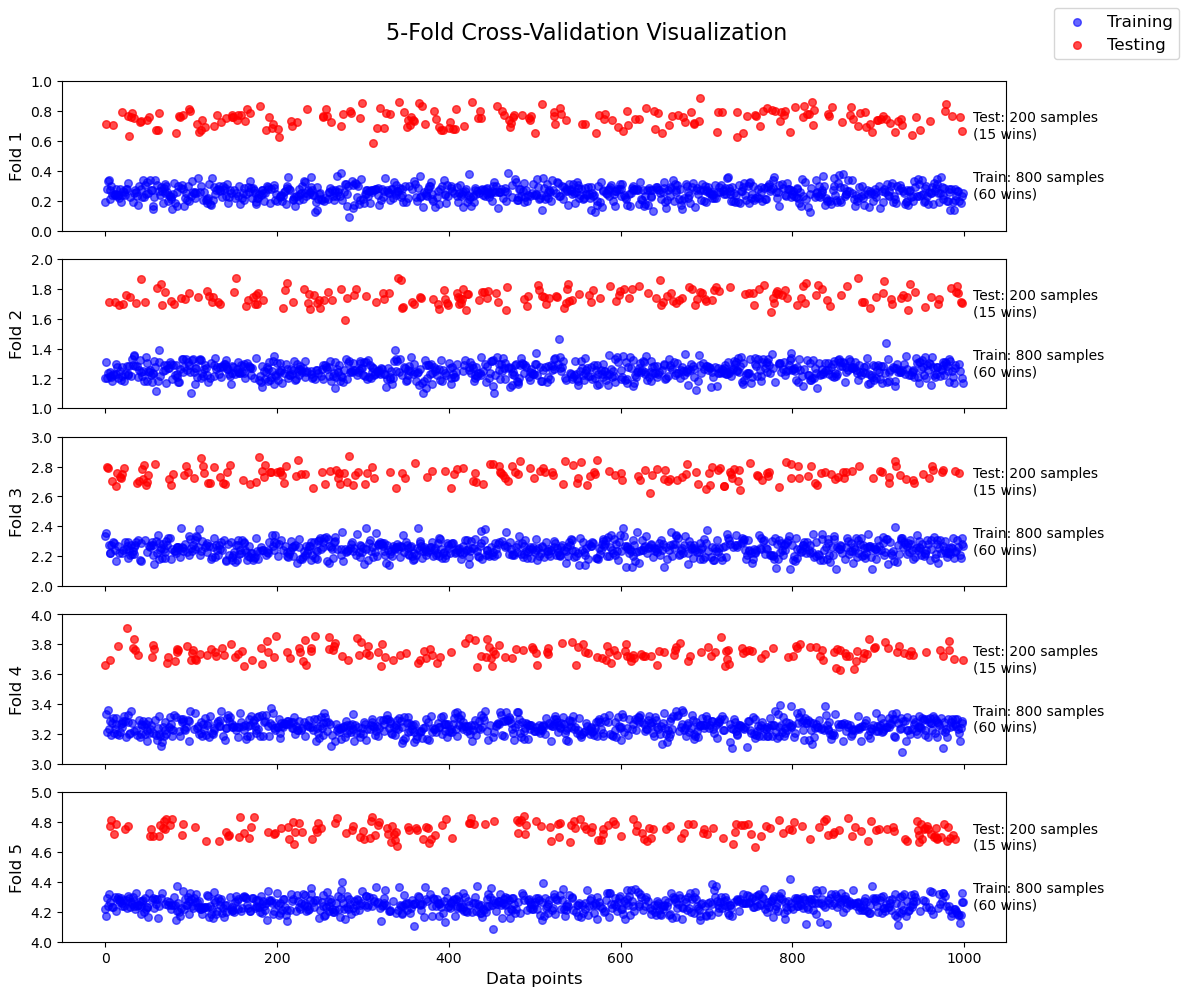

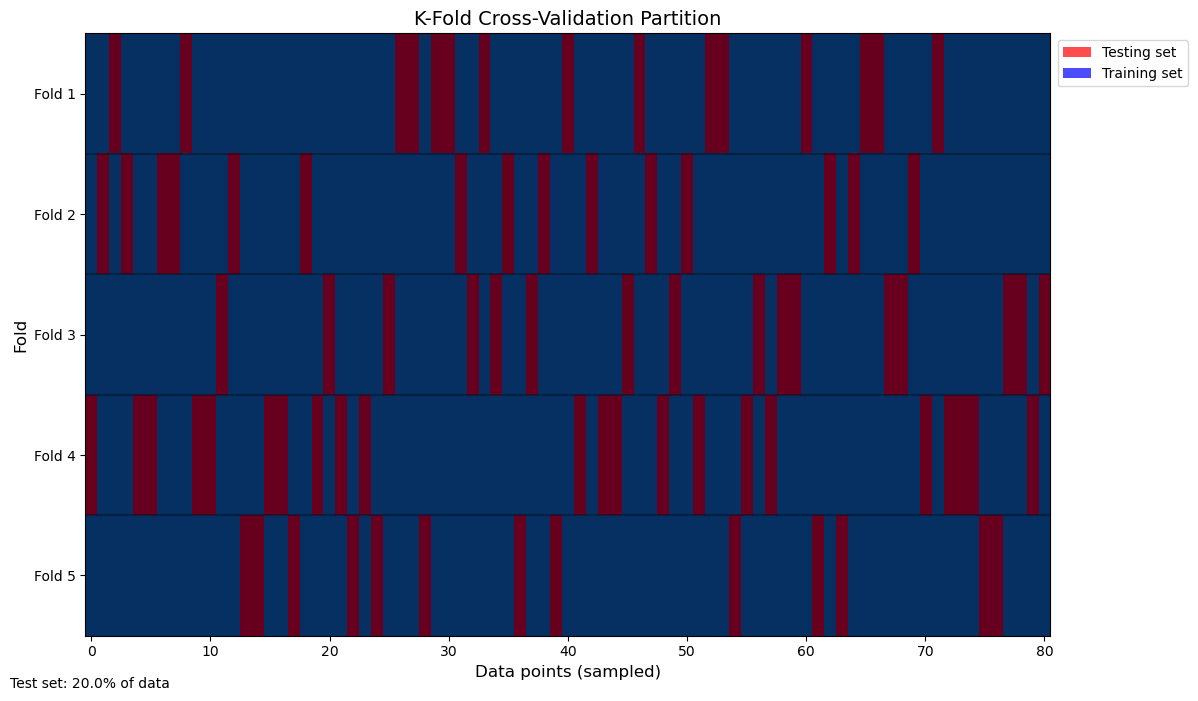

In [53]:
plot_kfold_visualization(X, y, kf, sample_size=1000)
kfold_partition(X, y, kf, sample_rate=0.05)

In [54]:
def plot_feature_importance(model, features):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importance)), importance[indices], align='center')
    plt.xticks(range(len(importance)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

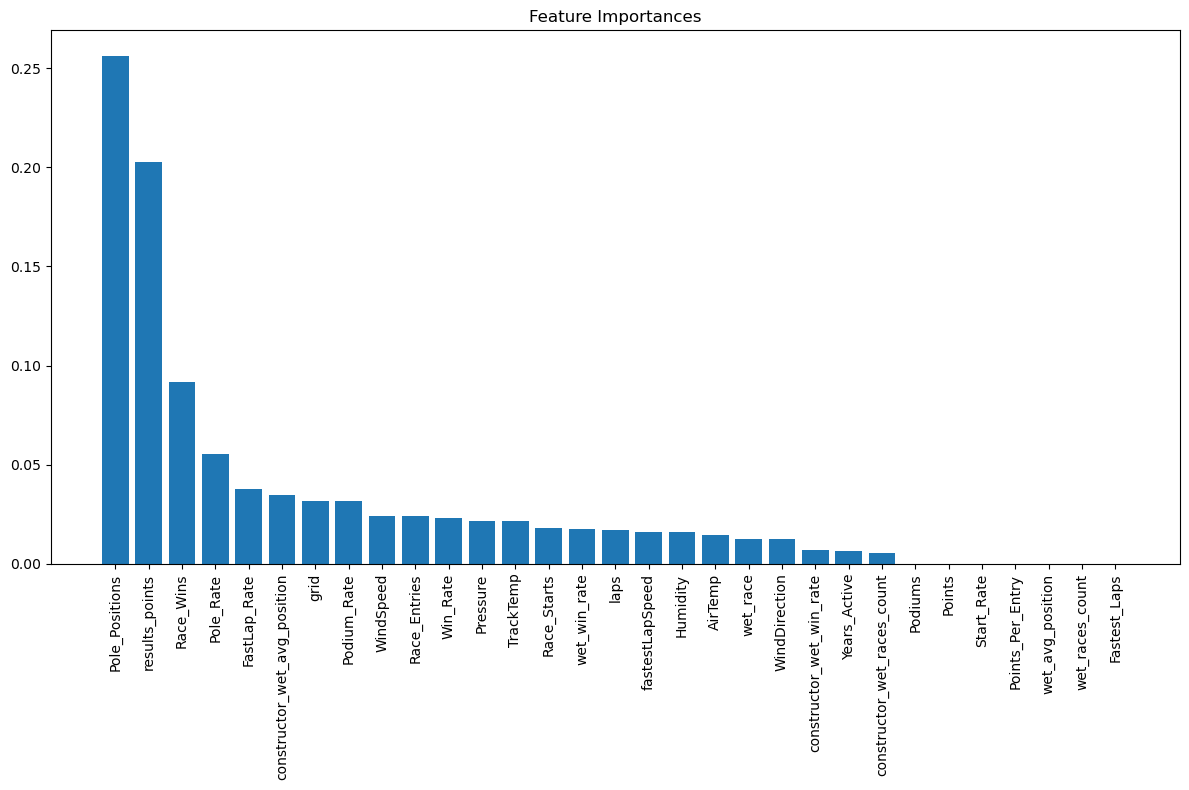

In [55]:
plot_feature_importance(model, features)

In [56]:
#make the race_winners dataframe

#make the lsits into numpy arrays to make next step easier
f_indicies = np.array(f_indicies)
f_predictions = np.array(f_predictions)
f_probs = np.array(f_probs)

race_winners = df.iloc[f_indicies].copy()
race_winners['predicted_winner'] = f_predictions
race_winners['predicted_winner_prob'] = f_probs

In [57]:
#get the names of all the races
unique_race_names = df['race_name'].unique()
print(unique_race_names)

['Australian Grand Prix' 'Bahrain Grand Prix' 'Chinese Grand Prix'
 'Azerbaijan Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'French Grand Prix' 'Austrian Grand Prix'
 'British Grand Prix' 'German Grand Prix' 'Hungarian Grand Prix'
 'Italian Grand Prix' 'Singapore Grand Prix' 'Russian Grand Prix'
 'Japanese Grand Prix' 'United States Grand Prix' 'Mexican Grand Prix'
 'Brazilian Grand Prix' 'Abu Dhabi Grand Prix' 'Belgian Grand Prix'
 'Tuscan Grand Prix' 'Eifel Grand Prix' 'Portuguese Grand Prix'
 'Emilia Romagna Grand Prix' 'Turkish Grand Prix' 'Qatar Grand Prix'
 'Styrian Grand Prix' 'Dutch Grand Prix' 'Mexico City Grand Prix'
 'São Paulo Grand Prix' 'Saudi Arabian Grand Prix' 'Miami Grand Prix'
 'Las Vegas Grand Prix']


In [58]:
def get_driver_prediction(race_name):
        filtered= race_winners[race_winners['race_name'] == race_name]
        
        if len(filtered) == 0:
            return f"No data for race: {race_name}"

        filtered= filtered.drop_duplicates(subset=['driverId'])

        #normalize so it all adds up to 100%
        total_prob = filtered['predicted_winner_prob'].sum()
        filtered['normalized_prob'] = filtered['predicted_winner_prob'] / total_prob
        
        return filtered.sort_values('normalized_prob', ascending=False)

In [59]:
def get_prediction(race_name, wet_probability=None):
    filtered= race_winners[race_winners['race_name'] == race_name]
        
    if len(filtered) == 0:
        return f"No data for race: {race_name}"

    filtered= filtered.drop_duplicates(subset=['driverId'])

    if wet_probability is None:
        historical_races = df[df['race_name'] == race_name]
        wet_probability = historical_races['wet_race'].mean() * 100
    
    total_prob = filtered['predicted_winner_prob'].sum()
    filtered['normalized_prob'] = filtered['predicted_winner_prob'] / total_prob

    dry_weight = (100 - wet_probability) / 100
    wet_weight = wet_probability / 100
    
    filtered['wet_adjusted_prob'] = filtered['normalized_prob'] * (
        dry_weight + wet_weight * (1 + filtered['wet_win_rate'] - filtered['Win_Rate'])
    )
    
    total_adj = filtered['wet_adjusted_prob'].sum()
    filtered['wet_adjusted_prob'] = filtered['wet_adjusted_prob'] / total_adj
    
    result = filtered.sort_values('wet_adjusted_prob', ascending=False)
    result.attrs['wet_race_probability'] = wet_probability

    return result

In [ ]:
country= "Abu Dhabi"
race= f"{country} Grand Prix"
results= get_prediction(race)
wet_prob = results.attrs['wet_race_probability']

#looked online for how to make it look nicer
print(f"\n--- Predictions for {race} ---")
print(f"Weather Forecast: {wet_prob:.1f}% chance of wet conditions")
print(f"{'Position':<8} {'Driver':<25} {'Constructor':<20} {'Win Probability':<15}")
print("-" * 70)

for i, (_, row) in enumerate(results.head(5).iterrows(), 1):
    driver_name = f"{row['forename']} {row['surname']}"
    constructor = row['constructor_name']
    probability = f"{row['normalized_prob']*100:.2f}%"
    print(f"{i:<8} {driver_name:<25} {constructor:<20} {probability:<15}")

#no lie i stole this code just so it looks nice. Please dont judge me


--- Predictions for Austrian Grand Prix ---
Weather Forecast: 26.4% chance of wet conditions
Position Driver                    Constructor          Win Probability
----------------------------------------------------------------------
1        Max Verstappen            Red Bull             99.41%         
2        Lewis Hamilton            Mercedes             0.35%          
3        Charles Leclerc           Ferrari              0.18%          
4        Valtteri Bottas           Mercedes             0.02%          
5        George Russell            Williams             0.01%          
